## Predicting kinetic constants 

Here, we will build models to predict $k_{cat}$, $K_M$, and $k_{cat}/K_M$ from:

+ 50 enzyme design features 

This completes our cleaning up the data to use in machine learning. In the next steps, we will evaluate the performance of machine learning algorithms in predicting the functional effect of each mutation, in terms of its effect on kcat, km, and kcat/km. 

## Kinetic constants benchmark, first attempt (emulating PLOS paper)

In [42]:
from glob import glob 
import pandas

sf = pandas.read_csv( 'data_sets/calculated/enzyme_design_talaris_2013.csv', index_col='description' )
low = sf.groupby( 'name' ).apply( lambda x: x.sort_values( by='total_score' ).sample( 10 ).mean() )

print len( low ), 'models'

166 models


In [43]:
from numpy import log, inf, nan

# experimental data 
experimental = pandas.read_csv( 'data_sets/experimental/plos2015.csv', index_col='name' )

# log and relative to wt 
wt = experimental.loc[ 'BglB' ]
experimental.drop( [ 'BglB' ] )
log_diff = log( experimental / wt ) - 1

print len( log_diff.kcat.dropna() ), 'kcat'
print len( log_diff.km.dropna() ), 'km'
print len( log_diff.kcatkm.dropna() ), 'kcat/km'

76 kcat
76 km
87 kcat/km


In [44]:
# add additional features 

#distances = pandas.read_csv( 'data_sets/distance_from_active_site.csv', index_col='name' ) 

In [45]:
joined = log_diff.join( low, lsuffix='low_' )

print len( joined ), 'joined' 

101 joined


So now we have 10 models (the lowest 10 by total_energy out of 100 simulations) of each protein, joined with experimental data. We don't have all pieces of experimental data for each protein, so there are some NaNs in the above dataframe, which scikit-learn doesn't deal very well with. We will clean up the data. 

In [46]:
from sklearn import preprocessing

constants = [ 'kcat', 'km', 'kcatkm' ]

# clean up data for sklearn
features = [ u'total_score', u'fa_rep', u'hbond_sc', u'tot_pstat_pm',
       u'tot_nlpstat_pm', u'tot_burunsat_pm', u'tot_hbond_pm',
       u'tot_NLconts_pm', u'tot_nlsurfaceE_pm', u'tot_total_charge',
       u'SR_1_total_score', u'SR_1_fa_rep', u'SR_1_hbond_sc',
       u'SR_1_hbond_pm', u'SR_1_burunsat_pm',
       u'SR_1_pstat_pm', u'SR_1_nlpstat_pm', u'SR_2_total_score',
       u'SR_2_fa_rep', u'SR_2_hbond_sc', u'SR_2_hbond_pm',
       u'SR_2_burunsat_pm', u'SR_2_pstat_pm', u'SR_2_nlpstat_pm',
       u'SR_3_total_score', u'SR_3_fa_rep', u'SR_3_hbond_sc', 
       u'SR_3_hbond_pm', u'SR_3_burunsat_pm', u'SR_3_pstat_pm',
       u'SR_3_nlpstat_pm', u'SR_4_total_score', u'SR_4_fa_rep',
       u'SR_4_hbond_sc', u'SR_4_hbond_pm',
       u'SR_4_burunsat_pm', u'SR_4_pstat_pm', u'SR_4_nlpstat_pm',
       u'SR_5_total_score', u'SR_5_fa_rep', u'SR_5_hbond_sc', 
       u'SR_5_interf_E_1_2', u'SR_5_dsasa_1_2', u'SR_5_hbond_pm',
       u'SR_5_burunsat_pm' ]

for constant in constants:
    work = joined[ features + [ constant ] ]
    work = work.replace( [ inf, -inf ], nan ).dropna()
    scaler = preprocessing.StandardScaler()
    J = scaler.fit_transform( work ) 
    work = pandas.DataFrame( J, columns=work.columns )
    work.to_csv( 'data_sets/tmp/{}.csv'.format( constant ) )

/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/ensemble/bagging.py:920: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


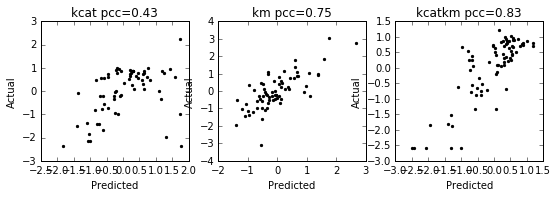

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import BaggingRegressor
from sklearn import preprocessing, cross_validation
from scipy.stats.stats import pearsonr

constants = [ 'kcat', 'km', 'kcatkm' ]

plt.figure( figsize=( 9, 2.5 ) ) 

for i, constant in enumerate( constants ):
    
    J = pandas.read_csv( 'data_sets/tmp/{}.csv'.format( constant ), index_col=0 ).as_matrix()  
    X = J[:, :-1]
    y = J[:, -1:].ravel()
    
    l1_ratio = [ .1, .5, .7, .9, .95, .99, 1 ]
    
    net = ElasticNetCV( l1_ratio=l1_ratio, cv=10, max_iter=-1 ) 
    bag = BaggingRegressor( net, n_estimators=1, n_jobs=-1, oob_score=True )
    bag.fit( X, y )
    preds = bag.predict( X )

    plt.subplot( 1, 3, i + 1 ) 
    plt.scatter( preds, y, marker='.', color='k' )
    plt.xlabel( 'Predicted' ); plt.ylabel( 'Actual' )
    r = pearsonr( preds, y )[0].round(2)
    plt.title( '{} pcc={}'.format( constant, r ) ) 

### Per-feature stratification 

Sampling all of the features 10 highest and 10 lowest rows to see if any of the sample subsets improve EN performance. Will also include a few more estimators 

In [48]:
# try sampling all the features to pick the lowest 10 models 

import pandas 
from numpy import inf, nan, log 
from sklearn import preprocessing 

# Rosetta features for 17400 Bagel protein models 
sf = pandas.read_csv( 'data_sets/calculated/enzyme_design_talaris_2014.csv' )
sf['name'] = sf.description.str.split( '_' ).str[ 1 ]

# constants to be included as above 
# experimental data, and also log compared to wild type as above 

In [49]:
G = sf.groupby( 'name' ) #20,000 x 100
feature_sets = []
for constant in constants:
    y = log_diff[ [ constant ] ]
    print constant,     
    for a in [ True, False ]:
        for feature in features:            
            print '.', 
            X = G.apply( lambda x: x.sort_values( by=feature, ascending=a ).head( 10 ).mean() )[ features ] 
            J = X.join( y ).replace( [ inf, -inf ], nan ).dropna()
            scaler = preprocessing.StandardScaler()
            J = scaler.fit_transform( J )
            feature_sets.append( ( constant, a, feature, J ) )
    print ''

kcat . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
km . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
kcatkm . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


In [50]:
import pickle

with open( 'data_sets/tmp/feature_sets.pkl', 'w' ) as fn:
    pickle.dump( feature_sets, fn ) 

In [51]:
# try EN on all feature sets

%matplotlib inline
import matplotlib.pyplot as plt 
from sklearn import cross_validation, preprocessing
from sklearn.linear_model import ElasticNetCV, SGDRegressor
from sklearn.ensemble import BaggingRegressor
from scipy.stats.stats import pearsonr
from numpy import log, mean
from glob import glob 
import pandas
import pickle 

from sklearn.cross_validation import cross_val_score, cross_val_predict

scores = []

L = [ .1, .5, .7, .9, .95, .99, 1 ]
cv = 10 

classifiers = [ 
    ( 'EN_auto_L1', ElasticNetCV( selection='random', cv=cv ) ),  
    ( 'SGD', SGDRegressor( penalty='elasticnet' ) ),  # stochastic gradient descent
    ( 'EN_with_manual_L1_ratio', ElasticNetCV( l1_ratio=L, cv=cv ) ), 
    ( 'EN_with_bagging', BaggingRegressor( ElasticNetCV( l1_ratio=L, cv=cv ), n_estimators=10 ) ), 
]

with open( 'feature_sets.pkl' ) as fn:
    loaded_feature_sets = pickle.load( fn ) 
    
for ( constant, a, feature, J ) in loaded_feature_sets[0:3]:
    
    X = J[:, :-1]
    y = J[:, -1:].ravel()
    
    for clf_short_name, clf in classifiers:

        result = {
            'classifier_short_name': clf_short_name,
            'classifier': clf.fit( X, y ),
            'y': y, 
            'X': X, 
            'predictions': clf.predict( X ), 
            'score': clf.score( X, y ),
            'constant': constant, 
            'ascending': a, 
            'feature': feature, 
            'cross_val_score': cross_val_score( clf, X, y ) 
        }
        
        scores.append( result ) 
        print 'appended', result['classifier_short_name']

scores = pandas.DataFrame( scores )
scores.to_pickle( 'data_sets/tmp/scores.pkl' ) 

appended EN_auto_L1
appended SGD
appended EN_with_manual_L1_ratio
appended EN_with_bagging
appended EN_auto_L1
appended SGD
appended EN_with_manual_L1_ratio
appended EN_with_bagging
appended EN_auto_L1
appended SGD
appended EN_with_manual_L1_ratio
appended EN_with_bagging


In [52]:
import pickle

with open( 'data_sets/tmp/scores.pkl' ) as fn:
    loaded_scores = pickle.load( fn ) 

In [53]:
loaded_scores.columns

Index([u'X', u'ascending', u'classifier', u'classifier_short_name',
       u'constant', u'cross_val_score', u'feature', u'predictions', u'score',
       u'y'],
      dtype='object')

In [54]:
def my_function( df ):
    return df.sort_values( 'score', ascending=False ).head( 5 ) 

low5 = scores.groupby( 'constant' ).apply( my_function ) 

print low5.columns

Index([u'X', u'ascending', u'classifier', u'classifier_short_name',
       u'constant', u'cross_val_score', u'feature', u'predictions', u'score',
       u'y'],
      dtype='object')


In [55]:
low5

X ascending  \
constant                                                                   
kcat     11  [[-0.185611689987, -0.160587584974, -1.8495402...      True   
         9   [[-0.185611689987, -0.160587584974, -1.8495402...      True   
         1   [[-0.171719291993, -0.153413538022, -2.0785239...      True   
         3   [[-0.171719291993, -0.153413538022, -2.0785239...      True   
         5   [[-0.170602985369, -0.15676900475, -1.74031641...      True   

                                                    classifier  \
constant                                                         
kcat     11  (ElasticNetCV(alphas=None, copy_X=True, cv=10,...   
         9   SGDRegressor(alpha=0.0001, average=False, epsi...   
         1   SGDRegressor(alpha=0.0001, average=False, epsi...   
         3   (ElasticNetCV(alphas=None, copy_X=True, cv=10,...   
         5   SGDRegressor(alpha=0.0001, average=False, epsi...   

            classifier_short_name constant  \
constant                                     
kcat     11       EN_with_bagging     kcat   
         9                    SGD     kcat   
         1                    SGD     kcat   
         3        EN_with_bagging     kcat   
         5                    SGD     kcat   

                                               cross_val_score      feature  \
constant                                                                      
kcat     11  [-0.316391091806, 0.104828386676, -0.968602550...     hbond_sc   
         9   [-0.152970243978, 0.117393904833, -0.779670217...     hbond_sc   
         1   [-0.114754799699, 0.0630527065472, -0.33665840...  total_score   
         3   [-0.0178616649697, -0.0234617803295, -0.459266...  total_score   
         5   [-0.111810491182, -0.0144014804468, -0.2154186...       fa_rep   

                                                   predictions     score  \
constant                                                                   
kcat     11  [0.426830779821, 0.471656792264, 0.03429466378...  0.509940   
         9   [0.267067754979, 0.478874322244, -0.1492476505...  0.491099   
         1   [-0.210276083464, -0.0488917697579, 0.59842108...  0.476861   
         3   [0.00788472541611, 0.0686692020993, 0.35133431...  0.461373   
         5   [-0.106075776719, 0.0653070491104, 0.820800236...  0.430831   

                                                             y  
constant                                                        
kcat     11  [0.930228452973, 0.567303558594, 0.59443494529...  
         9   [0.930228452973, 0.567303558594, 0.59443494529...  
         1   [0.930228452973, 0.567303558594, 0.59443494529...  
         3   [0.930228452973, 0.567303558594, 0.59443494529...  
         5   [0.930228452973, 0.567303558594, 0.59443494529...

In [35]:
for name, row in low5.iterrows():
    print name
    print row.classifier.l1_ratio_

('kcat', 0)
0.1
('kcat', 1)
0.1
('kcat', 2)
0.1


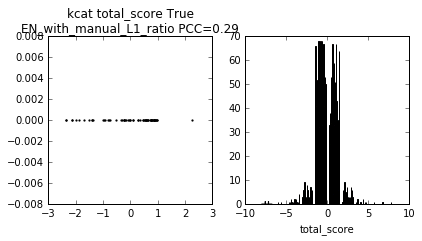

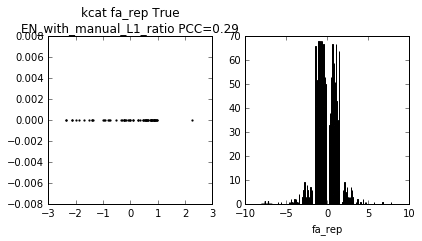

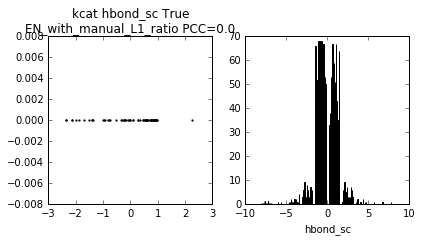

In [39]:
# with the bagging classifier 

for name, s in low5.iterrows():
    
    plt.figure( figsize=(10,3) )

    plt.subplot( 1, 3, 1 ) 
    pcc = pearsonr( s.y, s.predictions )[0].round( 2 )  
    plt.title( '{} {} {}\n{} PCC={}'.format( s.constant, s.feature, s.ascending, s.classifier_short_name, pcc ) )
    plt.scatter( s.y, s.predictions, linewidths=0, color='k', marker='.' ) 
    
    plt.subplot( 1, 3, 2 )
    plt.hist( X ) 
    plt.xlabel( s.feature ) 

    plt.show()
    #plt.close()



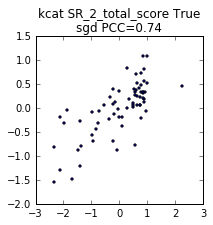

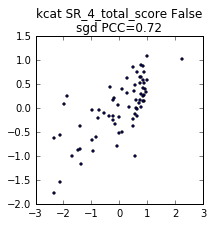

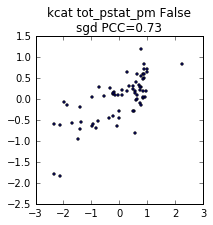

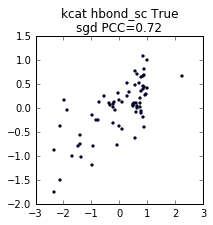

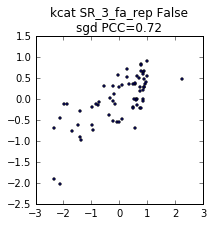

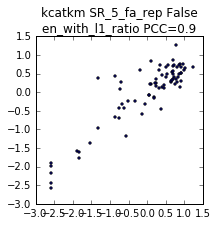

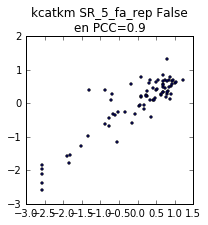

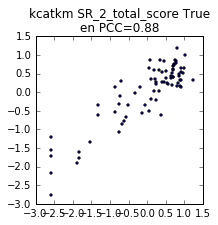

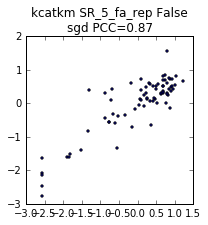

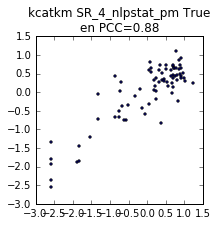

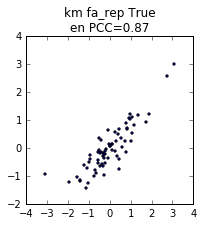

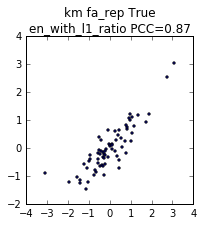

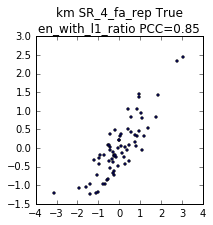

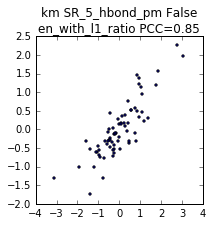

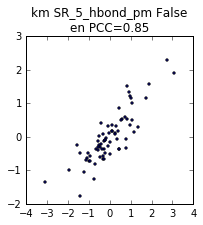

In [27]:
# without the bagging classifier 

for name, s in low5.iterrows():

    pcc = pearsonr( s.y, s.predictions )[0].round( 2 )  
    plt.figure( figsize=(3,3) ) 
    plt.title( '{} {} {}\n{} PCC={}'.format( s.constant, s.feature, s.ascending, s.classifier_short_name, pcc ) )
    plt.scatter( s.y, s.predictions, marker='.' ) 
    plt.show()


## Additional features

### Distance from active site 

In [41]:
# add distance from active site as a feature for every possible mutation  

from Bio.PDB.PDBParser import PDBParser 
from Bio.SeqUtils import IUPACData

parser = PDBParser()
structure = parser.get_structure( 'bglb', 'bglb.pdb' )

ligand = structure[0]['X']
for i in ligand:
    ligand_centroid = i['C5'] 

chain_a = structure[0]['A']
    
l = []
for i in range( 1, 445 ):
    res = chain_a[ i ]
    n = IUPACData.protein_letters_3to1[ res.get_resname().capitalize() ] 
    atom_1 = res['CA']
    distance = atom_1 - ligand_centroid
    for aa in IUPACData.protein_letters:
        l.append( ( '{}{}{}'.format( n, i, aa.upper() ), distance ) ) 
    
df = pandas.DataFrame( l, columns=[ 'name', 'distance' ] )  


df.to_csv( 'data_sets/distance_from_active_site.csv' ) 

## Stratch 

In [31]:
# Author: Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 clause

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

iris = load_iris()

X, y = iris.data, iris.target

# This dataset is way to high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Maybe some original features where good, too?
selection = SelectKBest(k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])

param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1, score=0.960784 -   0.0s
[CV] features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1, score=0.901961 -   0.0s
[CV] features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=0.1, features__univ_select__k=1, score=0.979167 -   0.0s
[CV] features__pca__n_components=1, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=1, features__univ_select__k=1, score=0.941176 -   0.0s

[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:    0.1s



[CV] features__pca__n_components=1, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=1, features__univ_select__k=1, score=0.921569 -   0.0s
[CV] features__pca__n_components=1, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=1, features__univ_select__k=1, score=0.979167 -   0.0s
[CV] features__pca__n_components=1, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=10, features__univ_select__k=1, score=0.960784 -   0.0s
[CV] features__pca__n_components=1, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=10, features__univ_select__k=1, score=0.921569 -   0.0s
[CV] features__pca__n_components=1, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=1, svm__C=10, features__univ_select__k=1, score=0.979167 -   0.0s
[CV] features__pca__n_components=1, svm__C=0.1, features__univ_select__k=2 
[CV]  features__pca__n_components=1, svm__C=0.1, fea

[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:    0.2s



[CV] features__pca__n_components=2, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=1, features__univ_select__k=1, score=0.941176 -   0.0s
[CV] features__pca__n_components=2, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=1, features__univ_select__k=1, score=0.979167 -   0.0s
[CV] features__pca__n_components=2, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=10, features__univ_select__k=1, score=0.980392 -   0.0s
[CV] features__pca__n_components=2, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=10, features__univ_select__k=1, score=0.941176 -   0.0s
[CV] features__pca__n_components=2, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=2, svm__C=10, features__univ_select__k=1, score=0.979167 -   0.0s
[CV] features__pca__n_components=2, svm__C=0.1, features__univ_select__k=2 
[CV]  features__pca__n_components=2, svm__C=0.1, fea

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.4s



[CV]  features__pca__n_components=3, svm__C=0.1, features__univ_select__k=1, score=0.979167 -   0.0s
[CV] features__pca__n_components=3, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=1, features__univ_select__k=1, score=1.000000 -   0.0s
[CV] features__pca__n_components=3, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=1, features__univ_select__k=1, score=0.941176 -   0.0s
[CV] features__pca__n_components=3, svm__C=1, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=1, features__univ_select__k=1, score=0.979167 -   0.0s
[CV] features__pca__n_components=3, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=10, features__univ_select__k=1, score=1.000000 -   0.0s
[CV] features__pca__n_components=3, svm__C=10, features__univ_select__k=1 
[CV]  features__pca__n_components=3, svm__C=10, features__univ_select__k=1, score=0.921569 -   0.0s
[CV] features__pca__n_compone

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.5s finished


In [176]:
# clean try at it (what?)

In [199]:
# features 

f = pandas.DataFrame()

# distance from active site 

distance_features = pandas.read_csv( 'data_sets/distance_from_active_site.csv', index_col=0 ) 
distance_features.set_index( 'name', inplace=True ) 

print distance_features.sample( 5 ) 

f['distance'] = distance_features.distance

print f.sample( 5 ) 
print len( f ), 'rows'

        distance
name            
D288G  21.533550
C54L   17.077085
R385R  23.580620
L171F  12.435019
L434M  22.921677
        distance
name            
H328T  17.296524
P319F  20.129499
K442Y  28.076277
Q69Q   25.309523
T2E    29.248558
8880 rows


In [200]:
# blosum scores from flat file 
# ftp://ftp.ncbi.nih.gov/blast/matrices/BLOSUM62

bsm = pandas.read_csv( 'blosum62.txt', sep='\s+', index_col=0 ) 
f['blosum62'] = [ bsm[ i[0] ][ i[-1] ] for i in f.index ]
print f.sample( 5 ) 
print len( f ), 'rows' 

        distance  blosum62
name                      
Y295I   8.555000        -1
D55K   19.611868        -1
A192W  16.758543        -3
F332D  15.382276        -3
S169N  13.790542         1
8880 rows


In [201]:
# ddg_monomer features 

ddg = pandas.read_csv( '/Users/alex/Documents/bagel-thermostability/protocols/results/apo_kellogg.out', sep='\s+', index_col='description' ).drop( 'ddG:', axis=1 )
f = f.join( ddg ).dropna()
print len( f ) 

68


In [202]:
# enzyme design features 

enzdes = pandas.read_csv( 'data_sets/scorefile.csv', index_col=0 )
enzdes = enzdes.groupby( 'name' ).apply( lambda x : x.head(10).mean() ) 

#enzdes.groupby( 'name' ).mean() 
#enzdes.set_index( 'name', inplace=True ) 
# = f.join( enzdes, rsuffix='_enzdes' ).dropna() #
#print len( f )

In [204]:
f.index - enzdes.index

/usr/local/bin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  if __name__ == '__main__':


Index([u'E164A', u'E164G', u'E164R', u'E353A', u'G174R', u'L122E', u'L122N',
       u'L402C', u'R297F', u'S169P', u'Y295A', u'Y295G', u'Y75H'],
      dtype='object')

In [223]:
import screed 

complete_list = []

for record in screed.open( 'bglb.fasta' ):
    for index, letter in enumerate( record.sequence ):
        for new_letter in 'ACDEFGHIKLMNPQRSTVWY':
            complete_list.append( letter + str( index + 1 ) + new_letter )
            
len( complete_list ) 

8900

In [224]:
lis = pandas.read_csv( 'mutant_list', header=None, names=['name'], index_col=0 ) 

d = f.index.difference( enzdes.index ).difference( lis.index ) 

In [226]:
for m in d:
    print m in complete_list 


True
True
True
True
True
True
True


In [181]:
# join with experimental 

# read in data 
# clean up data 

import pandas 

df = pandas.read_csv( 'data_sets/expression_cat.csv' ) 
df['expression'] = ( df.expression + 0.5 ) // 1 
df.dropna( inplace=True ) 
df.set_index( 'name', inplace=True ) 

J = f.join( df ).dropna() 
J.to_csv( 'J.csv' ) 
print len( J ) 

# select features 

select = ['distance', 'blosum62', 'total', 'fa_atr', 'fa_rep', 'fa_sol', 'fa_intra_rep', 'fa_elec', 'pro_close', 'hbond_sr_bb', 'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc', 'dslf_fa13', 'coordinate_constraint', 'angle_constraint', 'dihedral_constraint', 'rama', 'omega', 'fa_dun', 'p_aa_pp', 'ref', 'chainbreak', 'res_type_constraint', 'total_score', 'fa_rep_enzdes', 'hbond_sc_enzdes', 'all_cst', 'tot_pstat_pm', 'tot_nlpstat_pm', 'tot_burunsat_pm', 'tot_hbond_pm', 'tot_NLconts_pm', 'tot_nlsurfaceE_pm', 'tot_total_charge', 'tot_total_pos_charges', 'tot_total_neg_charges', 'tot_seq_recovery', 'SR_1', 'SR_1_total_score', 'SR_1_fa_rep', 'SR_1_hbond_sc', 'SR_1_all_cst', 'SR_1_hbond_pm', 'SR_1_burunsat_pm', 'SR_1_pstat_pm', 'SR_1_nlpstat_pm', 'SR_2', 'SR_2_total_score', 'SR_2_fa_rep', 'SR_2_hbond_sc', 'SR_2_all_cst', 'SR_2_hbond_pm', 'SR_2_burunsat_pm', 'SR_2_pstat_pm', 'SR_2_nlpstat_pm', 'SR_3', 'SR_3_total_score', 'SR_3_fa_rep', 'SR_3_hbond_sc', 'SR_3_all_cst', 'SR_3_hbond_pm', 'SR_3_burunsat_pm', 'SR_3_pstat_pm', 'SR_3_nlpstat_pm', 'SR_4', 'SR_4_total_score', 'SR_4_fa_rep', 'SR_4_hbond_sc', 'SR_4_all_cst', 'SR_4_hbond_pm', 'SR_4_burunsat_pm', 'SR_4_pstat_pm', 'SR_4_nlpstat_pm', 'SR_5', 'SR_5_total_score', 'SR_5_fa_rep', 'SR_5_hbond_sc', 'SR_5_all_cst', 'SR_5_interf_E_1_2', 'SR_5_dsasa_1_2', 'SR_5_hbond_pm', 'SR_5_burunsat_pm']
X = J[ select ] 
y = J[ 'expression' ] 

# plot all the features against experimental data 

# %matplotlib inline
# import matplotlib.pyplot as plt 

# for feature in X.columns:
#     plt.figure( figsize=( 3, 3 ) )
#     plt.scatter( X[ feature ], y )
#     plt.xlabel( feature ) 
#     plt.ylabel( 'SDS-PAGE' ) 
#     plt.show()


50


CV accuracy: 0.800 +/- 0.000


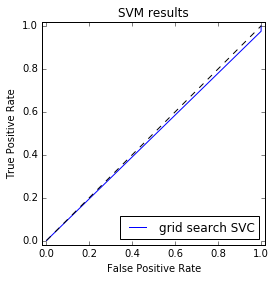

In [237]:
import numpy as np 
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipe_svc = Pipeline([
    ( 'scl', StandardScaler() ),
    ( 'clf', SVC() )
])

param_range = [ 0.001, 0.01, 0.1, 1., 10., 100. ]

param_grid = [
    { 
        'clf__C': param_range, 
        'clf__kernel': [ 'linear', 'rbf' ], 
    },
        { 
        'clf__C': param_range, 
        'clf__gamma': param_range, 
        'clf__kernel': [ 'rbf' ], 
    },
]

gs = GridSearchCV( estimator=pipe_svc, param_grid=param_grid, cv=5 ) 

#scores = cross_val_score( gs, X, y, scoring='accuracy', cv=5 )
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

predicted = cross_val_predict( gs, X, y, cv=10 )

fpr, tpr, __ = roc_curve( y, predicted ) 

plt.figure( figsize=(4,4) )
plt.plot( fpr, tpr ) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM results')
plt.legend( [ 'grid search SVC' ], loc='lower right' )
plt.show()

In [231]:
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import StratifiedKFold

gs.fit( X, y )
y_pred = gs.predict( X )
confmat = confusion_matrix(y_true=y, y_pred=y_pred)

print(confmat)

[[ 0 10]
 [ 0 40]]


In [233]:
# OK, let's decide on a list of 1000 mutants to model 

len( distance_features )

8880